In [1]:
from datetime import datetime
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import statsmodels.api as sm
import pyodbc
import urllib
import joblib
import json
from tqdm import tqdm
from sqlalchemy import create_engine 
from datetime import datetime, date
import sys
pd.set_option('display.max_columns', None)
pd.set_option('max_colwidth', 1000)

import warnings
warnings.filterwarnings("ignore")

/Users/anson_wang/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
df = pd.read_csv('YCcsv.csv')
df.head(3)

,Application_ID,PortFolioID,LoanID,CustType,OriginatedAmount,OrigYear,OrigMonth,OrigWeek,OriginationDate,FPDFA,FPDAA,TotalRealizedPayin,InstallmentNumber,PaidOffPaymentAmount,TransactionDate,PmtYear,PmtMonth,Days_Since_Orig,Weeks_Since_Orig,PaymentType,Payment_Number,PaymentStatus,weeks_between_orig_now
0,2775,1,I1003-0,NEW,300.0,2023,6,24,2023-06-12 11:40:12.980,0.0,0.0,82.45,1,82.45,2023-06-30 09:23:00.607,2023.0,6.0,18.0,3.0,Installment Pmt,1,D,31
1,2775,1,I1003-0,NEW,300.0,2023,6,24,2023-06-12 11:40:12.980,0.0,0.0,82.45,2,82.45,2023-07-14 11:03:02.783,2023.0,7.0,32.0,5.0,Installment Pmt,2,R,31
2,2775,1,I1003-0,NEW,300.0,2023,6,24,2023-06-12 11:40:12.980,0.0,0.0,82.45,2,142.45,2023-07-21 09:43:01.577,2023.0,7.0,39.0,6.0,Reset Pmt,3,R,31


In [ ]:
df = df[df.PaymentStatus=='D']

In [3]:
df_perf = df.groupby(['LoanID']).first().reset_index()
df_perf

,LoanID,Application_ID,PortFolioID,CustType,OriginatedAmount,OrigYear,OrigMonth,OrigWeek,OriginationDate,FPDFA,FPDAA,TotalRealizedPayin,InstallmentNumber,PaidOffPaymentAmount,TransactionDate,PmtYear,PmtMonth,Days_Since_Orig,Weeks_Since_Orig,PaymentType,Payment_Number
0,I1003-0,2775,1,NEW,300.0,2023,6,24,2023-06-12 11:40:12.980,0.0,0.0,82.45,1,82.45,2023-06-30 09:23:00.607,2023,6,18,3,Installment Pmt,1
1,I1004-0,2776,1,NEW,300.0,2023,6,24,2023-06-12 09:43:18.037,0.0,0.0,82.45,1,82.45,2023-06-21 13:03:00.823,2023,6,9,2,Installment Pmt,1
2,I1005-0,2785,1,NEW,500.0,2023,6,24,2023-06-12 10:32:33.317,0.0,0.0,135.45,1,135.45,2023-06-28 09:13:00.280,2023,6,16,3,Installment Pmt,1
3,I1006-0,2787,1,NEW,500.0,2023,6,24,2023-06-12 15:15:29.973,0.0,0.0,270.90,1,135.45,2023-06-23 10:03:00.453,2023,6,11,2,Installment Pmt,1
4,I1008-0,2791,1,NEW,500.0,2023,6,24,2023-06-12 14:20:55.117,0.0,0.0,812.70,1,135.45,2023-06-23 10:03:00.483,2023,6,11,2,Installment Pmt,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1430,I987-0,2745,1,NEW,400.0,2023,6,23,2023-06-09 14:08:19.730,1.0,1.0,108.95,4,108.95,2023-08-03 16:43:05.583,2023,8,55,8,Installment Pmt,1
1431,I99-0,308,1,NEW,500.0,2023,5,18,2023-05-04 11:39:06.733,0.0,0.0,484.40,1,69.20,2023-05-17 12:13:00.677,2023,5,13,2,Installment Pmt,1
1432,I993-0,2754,1,NEW,300.0,2023,6,23,2023-06-09 14:42:36.240,0.0,0.0,488.80,1,161.95,2023-06-30 09:23:00.577,2023,6,21,4,Installment Pmt,1
1433,I994-0,2755,1,NEW,300.0,2023,6,23,2023-06-09 14:29:16.390,0.0,0.0,341.60,1,42.70,2023-06-16 09:33:00.530,2023,6,7,2,Installment Pmt,1


In [4]:
df_perf.PaymentType.value_counts()

Installment Pmt    1327
Reset Pmt            56
Arr Pmt              30
Partial Pmt          13
Delinquent Pmt        8
3rd Party Pmt         1
Name: PaymentType, dtype: int64

In [5]:
df[(df.LoanID == 'I1142-0') & (df.InstallmentNumber ==1)]

,Application_ID,PortFolioID,LoanID,CustType,OriginatedAmount,OrigYear,OrigMonth,OrigWeek,OriginationDate,FPDFA,FPDAA,TotalRealizedPayin,InstallmentNumber,PaidOffPaymentAmount,TransactionDate,PmtYear,PmtMonth,Days_Since_Orig,Weeks_Since_Orig,PaymentType,Payment_Number
222,3130,1,I1142-0,NEW,500.0,2023,6,25,2023-06-23 11:47:24.247,1.0,0.0,855.0,1,132.5,2023-09-22 09:13:00.850,2023,9,91,14,Reset Pmt,5
223,3130,1,I1142-0,NEW,500.0,2023,6,25,2023-06-23 11:47:24.247,1.0,0.0,855.0,1,60.0,2023-10-05 09:23:00.213,2023,10,104,15,Reset Pmt,6


In [6]:
df.columns

Index(['Application_ID', 'PortFolioID', 'LoanID', 'CustType',
       'OriginatedAmount', 'OrigYear', 'OrigMonth', 'OrigWeek',
       'OriginationDate', 'FPDFA', 'FPDAA', 'TotalRealizedPayin',
       'InstallmentNumber', 'PaidOffPaymentAmount', 'TransactionDate',
       'PmtYear', 'PmtMonth', 'Days_Since_Orig', 'Weeks_Since_Orig',
       'PaymentType', 'Payment_Number'],
      dtype='object')

### All Customers

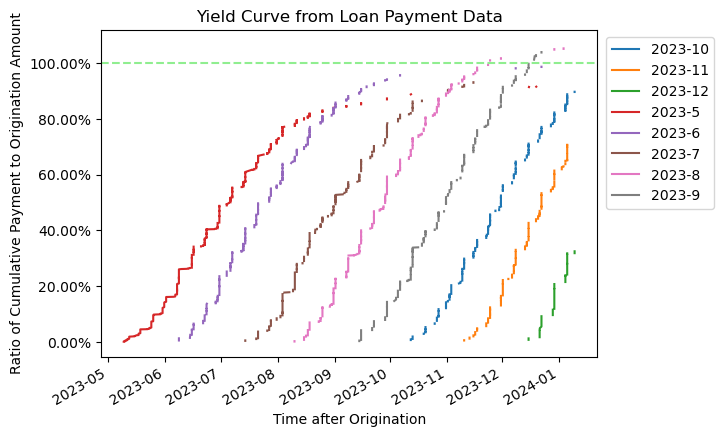

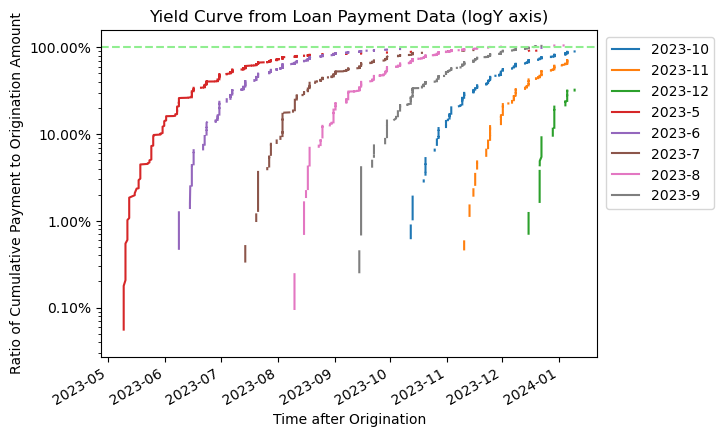

In [166]:
# Group by the origination month and year
df["OrigMonthYear"] = df["OrigYear"].astype(str) + "-" + df["OrigMonth"].astype(str)
grouped = df.groupby("OrigMonthYear")

# Initialize an empty dataframe to store the results
results = pd.DataFrame()

# Loop over each group
for name, group in grouped:
    # Calculate the total origination amount for each month
    loan_amounts = group.groupby("LoanID")["OriginatedAmount"].agg("first")
    
    # Calculate the total origination amount for each month
    total_orig_amount = loan_amounts.sum()
    
    # Calculate the cumulative sum of the payments for each month
    group = group.sort_values(by="TransactionDate")
    group["CumulativePayment"] = group["PaidOffPaymentAmount"].cumsum()
    
    # Calculate the ratio of cumulative payment to origination amount
    group["Ratio"] = group["CumulativePayment"] / total_orig_amount
    
    # Append the results to the dataframe
    results = results.append(group[["OrigMonthYear", "TransactionDate", "Ratio"]])

# Pivot the dataframe to have one column for each origination month
pivoted = results.pivot(index="TransactionDate", columns="OrigMonthYear", values="Ratio")

# Plot the yield curve
pivoted.plot(title="Yield Curve from Loan Payment Data")
plt.xlabel("Time after Origination")
plt.ylabel("Ratio of Cumulative Payment to Origination Amount")
plt.legend(bbox_to_anchor=(0, 0, 1.25, 1))
from matplotlib.ticker import PercentFormatter
plt.gca().yaxis.set_major_formatter(PercentFormatter (1.0, decimals=2))
plt.axhline(y=1.0, color='lightgreen', linestyle='--')
plt.show()


# Plot the yield curve
pivoted.plot(title="Yield Curve from Loan Payment Data (logY axis)")
plt.xlabel("Time after Origination")
plt.ylabel("Ratio of Cumulative Payment to Origination Amount")
plt.yscale("log")
plt.legend(bbox_to_anchor=(0, 0, 1.25, 1))
from matplotlib.ticker import PercentFormatter
plt.gca().yaxis.set_major_formatter(PercentFormatter (1.0, decimals=2))
plt.axhline(y=1.0, color='lightgreen', linestyle='--')
plt.show()


### New Customers
<li> Note: the final one or two payments that are deferred to the next loan term due to a top-off are not considered as part of the payoff amount.

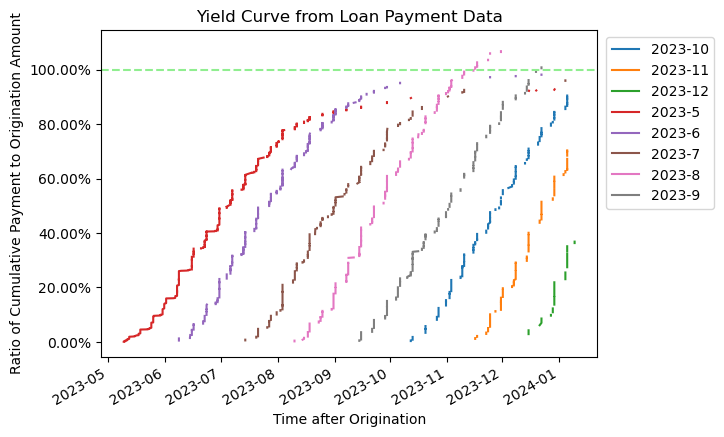

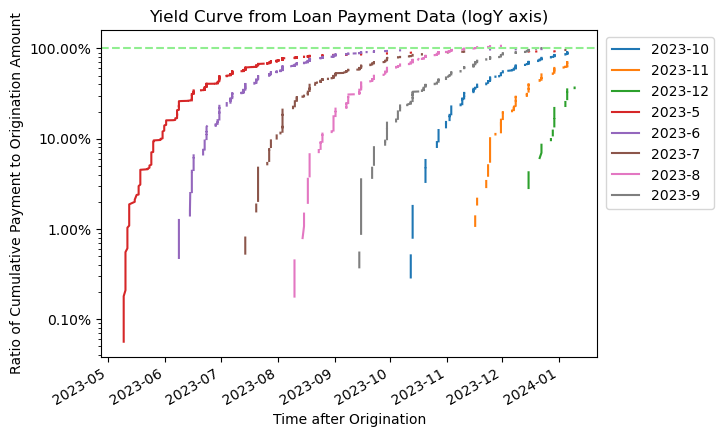

In [165]:
# Group by the origination month and year
grouped = df[df.CustType=='NEW'].groupby("OrigMonthYear")

# Initialize an empty dataframe to store the results
results = pd.DataFrame()

# Loop over each group
for name, group in grouped:
    # Calculate the total origination amount for each month
    loan_amounts = group.groupby("LoanID")["OriginatedAmount"].agg("first")
    
    # Calculate the total origination amount for each month
    total_orig_amount = loan_amounts.sum()
    
    # Calculate the cumulative sum of the payments for each month
    group = group.sort_values(by="TransactionDate")
    group["CumulativePayment"] = group["PaidOffPaymentAmount"].cumsum()
    
    # Calculate the ratio of cumulative payment to origination amount
    group["Ratio"] = group["CumulativePayment"] / total_orig_amount
    
    # Append the results to the dataframe
    results = results.append(group[["OrigMonthYear", "TransactionDate", "Ratio"]])

# Pivot the dataframe to have one column for each origination month
pivoted = results.pivot(index="TransactionDate", columns="OrigMonthYear", values="Ratio")

# Plot the yield curve
pivoted.plot(title="Yield Curve from Loan Payment Data")
plt.xlabel("Time after Origination")
plt.ylabel("Ratio of Cumulative Payment to Origination Amount")
plt.legend(bbox_to_anchor=(0, 0, 1.25, 1))
from matplotlib.ticker import PercentFormatter
plt.gca().yaxis.set_major_formatter(PercentFormatter (1.0, decimals=2))
plt.axhline(y=1.0, color='lightgreen', linestyle='--')
plt.show()


# Plot the yield curve
pivoted.plot(title="Yield Curve from Loan Payment Data (logY axis)")
plt.xlabel("Time after Origination")
plt.ylabel("Ratio of Cumulative Payment to Origination Amount")
plt.yscale("log")
plt.legend(bbox_to_anchor=(0, 0, 1.25, 1))
from matplotlib.ticker import PercentFormatter
plt.gca().yaxis.set_major_formatter(PercentFormatter (1.0, decimals=2))
plt.axhline(y=1.0, color='lightgreen', linestyle='--')
plt.show()

### Renewal Loans

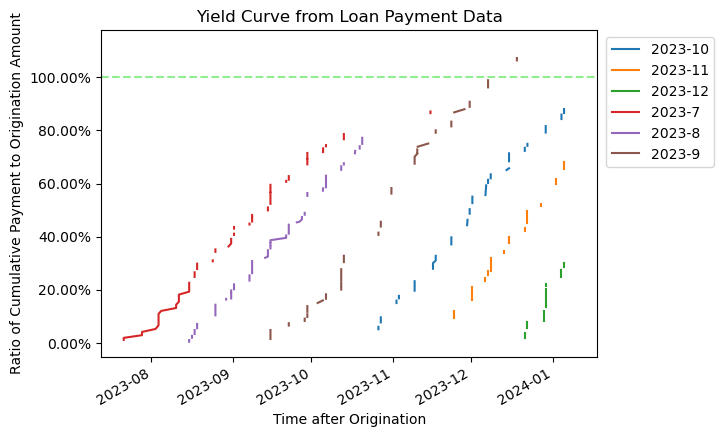

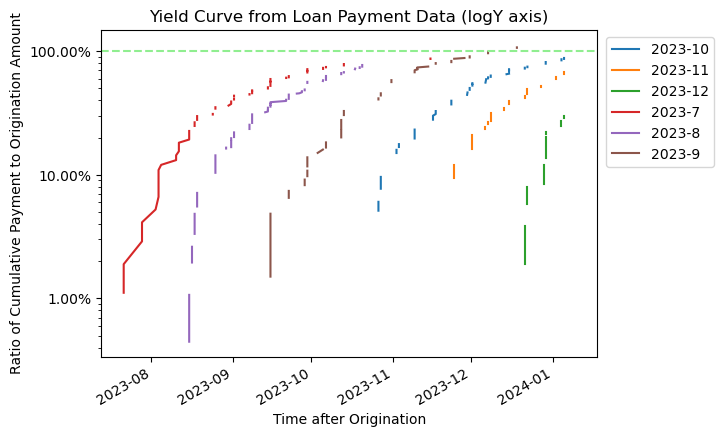

In [167]:

# Group by the origination month and year
grouped = df[df.CustType=='RENEWAL'].groupby("OrigMonthYear")

# Initialize an empty dataframe to store the results
results = pd.DataFrame()

# Loop over each group
for name, group in grouped:
    # Calculate the total origination amount for each month
    loan_amounts = group.groupby("LoanID")["OriginatedAmount"].agg("first")
    
    # Calculate the total origination amount for each month
    total_orig_amount = loan_amounts.sum()
    
    # Calculate the cumulative sum of the payments for each month
    group = group.sort_values(by="TransactionDate")
    group["CumulativePayment"] = group["PaidOffPaymentAmount"].cumsum()
    
    # Calculate the ratio of cumulative payment to origination amount
    group["Ratio"] = group["CumulativePayment"] / total_orig_amount
    
    # Append the results to the dataframe
    results = results.append(group[["OrigMonthYear", "TransactionDate", "Ratio"]])

# Pivot the dataframe to have one column for each origination month
pivoted = results.pivot(index="TransactionDate", columns="OrigMonthYear", values="Ratio")

# Plot the yield curve
pivoted.plot(title="Yield Curve from Loan Payment Data")
plt.xlabel("Time after Origination")
plt.ylabel("Ratio of Cumulative Payment to Origination Amount")
plt.legend(bbox_to_anchor=(0, 0, 1.25, 1))
from matplotlib.ticker import PercentFormatter
plt.gca().yaxis.set_major_formatter(PercentFormatter (1.0, decimals=2))
plt.axhline(y=1.0, color='lightgreen', linestyle='--')
plt.show()

# Plot the yield curve
pivoted.plot(title="Yield Curve from Loan Payment Data (logY axis)")
plt.xlabel("Time after Origination")
plt.ylabel("Ratio of Cumulative Payment to Origination Amount")
plt.yscale("log")
plt.legend(bbox_to_anchor=(0, 0, 1.25, 1))
from matplotlib.ticker import PercentFormatter
plt.gca().yaxis.set_major_formatter(PercentFormatter (1.0, decimals=2))
plt.axhline(y=1.0, color='lightgreen', linestyle='--')
plt.show()



### Repeat Customers

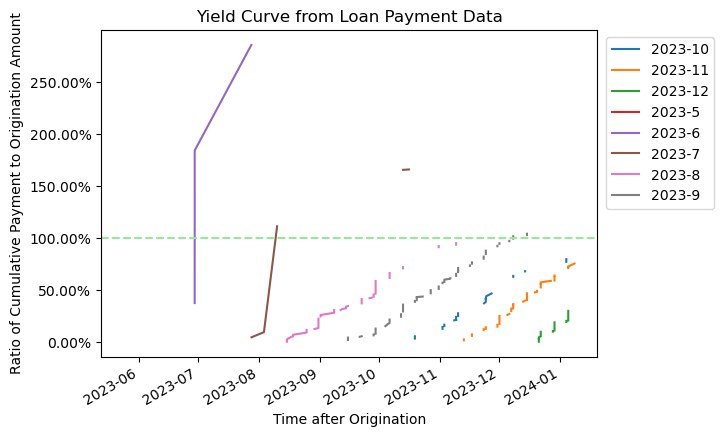

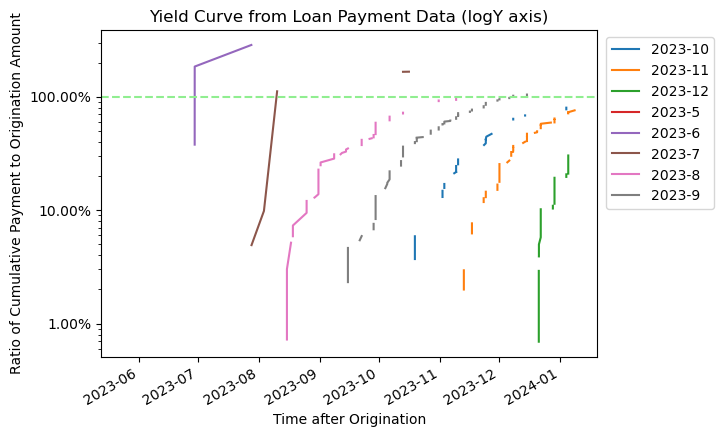

In [168]:

# Group by the origination month and year
grouped = df[df.CustType=='REPEAT'].groupby("OrigMonthYear")

# Initialize an empty dataframe to store the results
results = pd.DataFrame()

# Loop over each group
for name, group in grouped:
    # Calculate the total origination amount for each month
    loan_amounts = group.groupby("LoanID")["OriginatedAmount"].agg("first")
    
    # Calculate the total origination amount for each month
    total_orig_amount = loan_amounts.sum()
    
    # Calculate the cumulative sum of the payments for each month
    group = group.sort_values(by="TransactionDate")
    group["CumulativePayment"] = group["PaidOffPaymentAmount"].cumsum()
    
    # Calculate the ratio of cumulative payment to origination amount
    group["Ratio"] = group["CumulativePayment"] / total_orig_amount
    
    # Append the results to the dataframe
    results = results.append(group[["OrigMonthYear", "TransactionDate", "Ratio"]])

# Pivot the dataframe to have one column for each origination month
pivoted = results.pivot(index="TransactionDate", columns="OrigMonthYear", values="Ratio")

# Plot the yield curve
pivoted.plot(title="Yield Curve from Loan Payment Data")
plt.xlabel("Time after Origination")
plt.ylabel("Ratio of Cumulative Payment to Origination Amount")
plt.legend(bbox_to_anchor=(0, 0, 1.25, 1))
from matplotlib.ticker import PercentFormatter
plt.gca().yaxis.set_major_formatter(PercentFormatter (1.0, decimals=2))
plt.axhline(y=1.0, color='lightgreen', linestyle='--')
plt.show()


# Plot the yield curve
pivoted.plot(title="Yield Curve from Loan Payment Data (logY axis)")
plt.xlabel("Time after Origination")
plt.ylabel("Ratio of Cumulative Payment to Origination Amount")
plt.yscale("log")
plt.legend(bbox_to_anchor=(0, 0, 1.25, 1))
from matplotlib.ticker import PercentFormatter
plt.gca().yaxis.set_major_formatter(PercentFormatter (1.0, decimals=2))
plt.axhline(y=1.0, color='lightgreen', linestyle='--')
plt.show()



## Project the Future CashFlows??

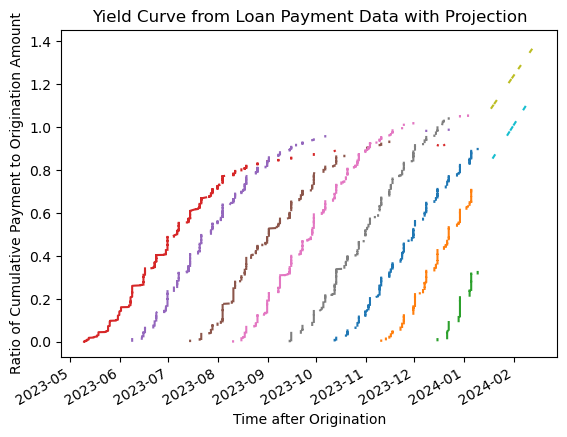

In [144]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
from datetime import date, datetime, time, timedelta
from random import seed, randrange, uniform

# Group by the origination month and year
df["OrigMonthYear"] = df["OrigYear"].astype(str) + "-" + df["OrigMonth"].astype(str)
grouped = df.groupby("OrigMonthYear", as_index=False)

# Initialize an empty dataframe to store the results
results = pd.DataFrame()

# Define a function to fit a linear regression model and predict the future values for each month
def project(group):
    # Calculate the total origination amount for each loan ID
    loan_amounts = group.groupby("LoanID")["OriginatedAmount"].agg("first")
    
    # Calculate the total origination amount for each month
    total_orig_amount = loan_amounts.sum()
    
    # Calculate the cumulative sum of the payments for each month
    group = group.sort_values(by="TransactionDate")
    group["CumulativePayment"] = group["PaidOffPaymentAmount"].cumsum()
    
    # Calculate the ratio of cumulative payment to origination amount
    group["Ratio"] = group["CumulativePayment"] / total_orig_amount
    
    # Fit a linear regression model to the data
    x = group["Days_Since_Orig"].values # Use the days since origination as the independent variable
    y = group["Ratio"].values # Use the ratio as the dependent variable
    slope, intercept, r_value, p_value, std_err = stats.linregress(x, y) # Get the regression parameters
    
    if group['OrigMonthYear'].values[0] == '2023-11':
        # Predict the future values using the model
        future_days = np.arange(x.max() + 1, x.max() + 31) # Generate 30 future days
        future_ratios = slope * future_days + intercept # Predict the future ratios using the model equation

        # Add the future values to the group dataframe
        future_dates = pd.to_datetime(future_days, unit="D", origin=group["TransactionDate"].min()) # Convert the future days to datetime format
        future_df = pd.DataFrame(future_ratios, index=future_dates, columns=["Projection"]) # Create a dataframe for the future values
        future_df['OrigMY'] = group['OrigMonthYear'].values[0]
        group = pd.concat([group, future_df], axis=1) # Concatenate the group and future dataframes
    
    if group['OrigMonthYear'].values[0] == '2023-10':
        # Predict the future values using the model
        future_days = np.arange(x.max() + 1, x.max() + 31) # Generate 30 future days
        future_ratios = slope * future_days + intercept # Predict the future ratios using the model equation

        # Add the future values to the group dataframe
        future_dates = pd.to_datetime(future_days, unit="D", origin=group["TransactionDate"].min()) # Convert the future days to datetime format
        future_df = pd.DataFrame(future_ratios, index=future_dates, columns=["Projection"]) # Create a dataframe for the future values
        future_df['OrigMY'] = group['OrigMonthYear'].values[0]
        group = pd.concat([group, future_df], axis=1) # Concatenate the group and future dataframes
    
    # Return the group dataframe
    return group

# Apply the function to each group of the dataframe
results = grouped.apply(project)
results.loc[results['TransactionDate'].isnull(),'TransactionDate'] = [i[1] + timedelta(seconds = uniform(5, 20))  for i in results.loc[results['TransactionDate'].isnull()].index]
try:
    results.loc[results['OrigMonthYear'].isnull(),'OrigMonthYear'] = [i for i in results.loc[results['OrigMonthYear'].isnull()].OrigMY]
    pivoted = results.pivot(index="TransactionDate", columns="OrigMonthYear", values=['Ratio','Projection'])
except: 
    pivoted = results.pivot(index="TransactionDate", columns="OrigMonthYear", values=['Ratio'])
# Pivot the dataframe to have one column for each origination month and the projection


# Plot the yield curve and the projection
pivoted.plot(title="Yield Curve from Loan Payment Data with Projection")
plt.xlabel("Time after Origination")
plt.ylabel("Ratio of Cumulative Payment to Origination Amount")
plt.legend().remove()
plt.show()


# further modification: continuation of lines and colors etc,....

In [180]:
MonthlyPayin = df.groupby(['OrigYear','OrigMonth'])['PaidOffPaymentAmount'].sum().reset_index()
MonthlyOrig = df_perf.groupby(['OrigYear','OrigMonth'])['OriginatedAmount'].sum().reset_index()
Monthly_Perf = MonthlyOrig.merge(MonthlyPayin, on =['OrigYear','OrigMonth'])
Monthly_Perf['Payin Ratio'] = Monthly_Perf['PaidOffPaymentAmount'] / Monthly_Perf['OriginatedAmount']
Monthly_Perf

,OrigYear,OrigMonth,OriginatedAmount,PaidOffPaymentAmount,Payin Ratio
0,2023,5,124050.00,114681.43,0.924477
1,2023,6,88650.00,88072.50,0.993486
2,2023,7,72800.00,69783.74,0.958568
3,2023,8,106700.00,112565.20,1.054969
4,2023,9,80000.00,85256.06,1.065701
5,2023,10,85300.00,76582.86,0.897806
6,2023,11,74650.00,53831.49,0.721118
7,2023,12,71035.25,23087.86,0.325020


In [59]:
### New visual
df = pd.read_csv('YCcsv.csv')
df.head(3)

,Application_ID,PortFolioID,LoanID,CustType,OriginatedAmount,OrigYear,OrigMonth,OrigWeek,OriginationDate,FPDFA,FPDAA,TotalRealizedPayin,InstallmentNumber,PaidOffPaymentAmount,TransactionDate,PmtYear,PmtMonth,Days_Since_Orig,Weeks_Since_Orig,PaymentType,Payment_Number,PaymentStatus,weeks_between_orig_now
0,2775,1,I1003-0,NEW,300.0,2023,6,24,2023-06-12 11:40:12.980,0.0,0.0,82.45,1,82.45,2023-06-30 09:23:00.607,2023.0,6.0,18.0,3.0,Installment Pmt,1,D,31
1,2775,1,I1003-0,NEW,300.0,2023,6,24,2023-06-12 11:40:12.980,0.0,0.0,82.45,2,82.45,2023-07-14 11:03:02.783,2023.0,7.0,32.0,5.0,Installment Pmt,2,R,31
2,2775,1,I1003-0,NEW,300.0,2023,6,24,2023-06-12 11:40:12.980,0.0,0.0,82.45,2,142.45,2023-07-21 09:43:01.577,2023.0,7.0,39.0,6.0,Reset Pmt,3,R,31


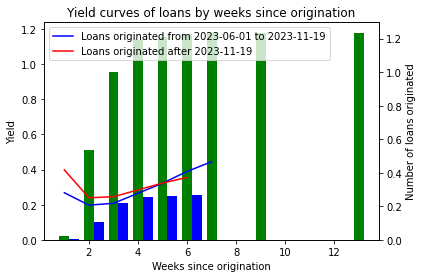

In [69]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Read table from CSV file or create DataFrame
# df = pd.read_csv("loan_payments.csv")

# Filter DataFrame by OriginationDate
df1 = df[(df["OriginationDate"] >= "2023-06-01") & (df["OriginationDate"] <= "2023-11-19")]
df2 = df[(df["OriginationDate"] > "2023-11-19")]

# Calculate total PaidOffPaymentAmount by grouping by Weeks_Since_Orig
df1_paid = df1[df1.PaymentStatus == 'D'].groupby("Weeks_Since_Orig")["PaidOffPaymentAmount"].sum().cumsum()
df2_paid = df2[df2.PaymentStatus == 'D'].groupby("Weeks_Since_Orig")["PaidOffPaymentAmount"].sum().cumsum()

# Transform the table by dropping duplicate rows for each LoanID and Weeks_Since_Orig
df1 = df1.groupby('LoanID').nth(0).sort_values(by='TransactionDate')
df2 = df2.groupby('LoanID').nth(0).sort_values(by='TransactionDate')

# Calculate total OriginatedAmount by grouping by Weeks_Since_Orig
df1_orig = df1.groupby("Weeks_Since_Orig")["OriginatedAmount"].sum().cumsum()
df2_orig = df2.groupby("Weeks_Since_Orig")["OriginatedAmount"].sum().cumsum()

# Calculate yields
df1_yield = df1_paid / df1_orig
df2_yield = df2_paid / df2_orig

# Plot yield curves
plt.plot(df1_yield.index, df1_yield, color="blue", label="Loans originated from 2023-06-01 to 2023-11-19")
plt.plot(df2_yield.index, df2_yield, color="red", label="Loans originated after 2023-11-19")

# Add title, labels, and legend
plt.title("Yield curves of loans by weeks since origination")
plt.xlabel("Weeks since origination")
plt.ylabel("Yield")
plt.legend()

# Create DataFrame with count of loans originated
df_count1 = df1.groupby("Weeks_Since_Orig").size().cumsum().to_frame("Count")
df_count2 = df2.groupby("Weeks_Since_Orig").size().cumsum().to_frame("Count")

# Plot bar chart
plt.bar(df_count1.index, df_count1["Count"]*0.001, width=0.4, color="green", label="Before")
plt.bar(df_count2.index+0.4, df_count2["Count"]*0.001, width=0.4, color="blue", label="After")

# Add secondary y-axis label and adjust scale
plt.twinx()
plt.ylabel("Number of loans originated")
plt.ylim(0, max(df_count1["Count"]) * 1.1*0.001)


# Show plot
plt.show()


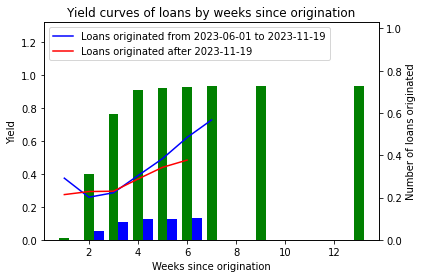

In [67]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Read table from CSV file or create DataFrame
# df = pd.read_csv("loan_payments.csv")

# Filter DataFrame by OriginationDate
df1 = df[(df["OriginationDate"] >= "2023-06-01") & (df["OriginationDate"] <= "2023-11-19") & (df.CustType=='NEW')]
df2 = df[(df["OriginationDate"] > "2023-11-19") & (df.CustType=='NEW')]

# Calculate total PaidOffPaymentAmount by grouping by Weeks_Since_Orig
df1_paid = df1.groupby("Weeks_Since_Orig")["PaidOffPaymentAmount"].sum().cumsum()
df2_paid = df2.groupby("Weeks_Since_Orig")["PaidOffPaymentAmount"].sum().cumsum()

# Transform the table by dropping duplicate rows for each LoanID and Weeks_Since_Orig
df1 = df1.groupby('LoanID').nth(0).sort_values(by='Weeks_Since_Orig')

df2 = df2.groupby('LoanID').nth(0).sort_values(by='Weeks_Since_Orig')

# Calculate total OriginatedAmount by grouping by Weeks_Since_Orig
df1_orig = df1.groupby("Weeks_Since_Orig")["OriginatedAmount"].sum().cumsum()
df2_orig = df2.groupby("Weeks_Since_Orig")["OriginatedAmount"].sum().cumsum()

# Calculate yields
df1_yield = df1_paid / df1_orig
df2_yield = df2_paid / df2_orig

# Plot yield curves
plt.plot(df1_yield.index, df1_yield, color="blue", label="Loans originated from 2023-06-01 to 2023-11-19")
plt.plot(df2_yield.index, df2_yield, color="red", label="Loans originated after 2023-11-19")

# Add title, labels, and legend
plt.title("Yield curves of loans by weeks since origination")
plt.xlabel("Weeks since origination")
plt.ylabel("Yield")
plt.legend()

# Create DataFrame with count of loans originated
df_count1 = df1.groupby("Weeks_Since_Orig").size().cumsum().to_frame("Count")
df_count2 = df2.groupby("Weeks_Since_Orig").size().cumsum().to_frame("Count")

# Plot bar chart
plt.bar(df_count1.index, df_count1["Count"]*0.001, width=0.4, color="green", label="Before")
plt.bar(df_count2.index+0.4, df_count2["Count"]*0.001, width=0.4, color="blue", label="After")

# Add secondary y-axis label and adjust scale
plt.twinx()
plt.ylabel("Number of loans originated")
plt.ylim(0, max(df_count1["Count"]) * 1.1*0.001)


# Show plot
plt.show()


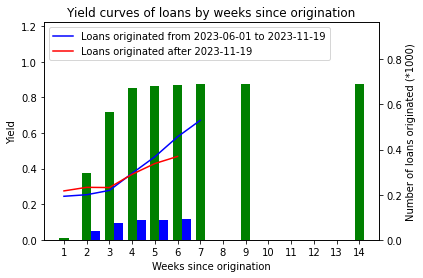

In [64]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Read table from CSV file or create DataFrame
# df = pd.read_csv("loan_payments.csv")

# Filter DataFrame by OriginationDate
df1 = df[(df["OriginationDate"] >= "2023-06-01") & (df["OriginationDate"] <= "2023-11-01") & (df.CustType=='NEW') & (~df.PaymentType.isin(['Reset Pmt', 'Arr Pmt']))]
df2 = df[(df["OriginationDate"] > "2023-11-25") & (df.CustType=='NEW')]

# Calculate total PaidOffPaymentAmount by grouping by Weeks_Since_Orig
df1_paid = df1.groupby("Weeks_Since_Orig")["PaidOffPaymentAmount"].sum().cumsum()
df2_paid = df2.groupby("Weeks_Since_Orig")["PaidOffPaymentAmount"].sum().cumsum()

# Transform the table by dropping duplicate rows for each LoanID and Weeks_Since_Orig
df1 = df1.groupby('LoanID').nth(0).sort_values(by='Weeks_Since_Orig')

df2 = df2.groupby('LoanID').nth(0).sort_values(by='Weeks_Since_Orig')

# Calculate total OriginatedAmount by grouping by Weeks_Since_Orig
df1_orig = df1.groupby("Weeks_Since_Orig")["OriginatedAmount"].sum().cumsum()
df2_orig = df2.groupby("Weeks_Since_Orig")["OriginatedAmount"].sum().cumsum()

# Calculate yields
df1_yield = df1_paid / df1_orig
df2_yield = df2_paid / df2_orig

# Plot yield curves
plt.plot(df1_yield.index.astype(int), df1_yield, color="blue", label="Loans originated from 2023-06-01 to 2023-11-19")
plt.plot(df2_yield.index.astype(int), df2_yield, color="red", label="Loans originated after 2023-11-19")

# Add title, labels, and legend
plt.title("Yield curves of loans by weeks since origination")
plt.xlabel("Weeks since origination")
plt.ylabel("Yield")
plt.xticks(df1_yield.index.astype(int))
plt.legend()

# Create DataFrame with count of loans originated
df_count1 = df1.groupby("Weeks_Since_Orig").size().cumsum().to_frame("Count")
df_count2 = df2.groupby("Weeks_Since_Orig").size().cumsum().to_frame("Count")

# Plot bar chart
plt.bar(df_count1.index, df_count1["Count"]*0.001, width=0.4, color="green", label="Before")
plt.bar(df_count2.index+0.4, df_count2["Count"]*0.001, width=0.4, color="blue", label="After")

# Add secondary y-axis label and adjust scale
plt.twinx()
plt.ylabel("Number of loans originated (*1000)")
plt.ylim(0, max(df_count1["Count"]) * 1.1*0.001)


# Show plot
plt.show()


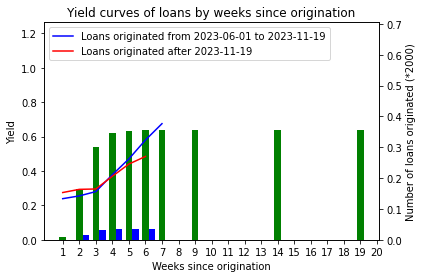

In [70]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Read table from CSV file or create DataFrame
# df = pd.read_csv("loan_payments.csv")

# Filter DataFrame by OriginationDate
df1 = df[(df["OriginationDate"] >= "2023-05-01") & (df["OriginationDate"] <= "2023-11-19") & (df.CustType=='NEW') & (~df.PaymentType.isin(['Reset Pmt', 'Arr Pmt']))]
df2 = df[(df["OriginationDate"] > "2023-11-19") & (df.CustType=='NEW')]

# Calculate total PaidOffPaymentAmount by grouping by Weeks_Since_Orig
df1_paid = df1.groupby("Weeks_Since_Orig")["PaidOffPaymentAmount"].sum().cumsum()
df2_paid = df2.groupby("Weeks_Since_Orig")["PaidOffPaymentAmount"].sum().cumsum()

# Transform the table by dropping duplicate rows for each LoanID and Weeks_Since_Orig
df1 = df1.groupby('LoanID').nth(0).sort_values(by='Weeks_Since_Orig')

df2 = df2.groupby('LoanID').nth(0).sort_values(by='Weeks_Since_Orig')

# Calculate total OriginatedAmount by grouping by Weeks_Since_Orig
df1_orig = df1.groupby("Weeks_Since_Orig")["OriginatedAmount"].sum().cumsum()
df2_orig = df2.groupby("Weeks_Since_Orig")["OriginatedAmount"].sum().cumsum()

# Calculate yields
df1_yield = df1_paid / df1_orig
df2_yield = df2_paid / df2_orig

# Plot yield curves
plt.plot(df1_yield.index.astype(int), df1_yield, color="blue", label="Loans originated from 2023-06-01 to 2023-11-19")
plt.plot(df2_yield.index.astype(int), df2_yield, color="red", label="Loans originated after 2023-11-19")

# Add title, labels, and legend
plt.title("Yield curves of loans by weeks since origination")
plt.xlabel("Weeks since origination")
plt.ylabel("Yield")
plt.xticks(df1_yield.index.astype(int))
plt.legend()

# Create DataFrame with count of loans originated
df_count1 = df1.groupby("Weeks_Since_Orig").size().cumsum().to_frame("Count")
df_count2 = df2.groupby("Weeks_Since_Orig").size().cumsum().to_frame("Count")

# Plot bar chart
plt.bar(df_count1.index, df_count1["Count"]*0.0005, width=0.4, color="green", label="Before")
plt.bar(df_count2.index+0.4, df_count2["Count"]*0.0005, width=0.4, color="blue", label="After")

# Add secondary y-axis label and adjust scale
plt.twinx()
plt.ylabel("Number of loans originated (*2000)")
plt.ylim(0, max(df_count1["Count"]) * 1.1*0.0005)


# Show plot
plt.show()


In [71]:
df1_paid

Weeks_Since_Orig
1.0       3467.00
2.0      64266.05
3.0     127275.40
4.0     197918.65
5.0     250586.58
6.0     312532.49
7.0     365159.53
8.0     423777.97
9.0     471834.95
10.0    520495.13
11.0    558803.66
12.0    596665.69
13.0    624313.91
14.0    638778.44
15.0    644582.80
16.0    648354.42
17.0    650960.65
18.0    652058.02
19.0    652968.67
20.0    653504.57
21.0    655092.86
22.0    655306.71
23.0    655842.61
26.0    655913.28
31.0    655954.45
37.0    655970.05
Name: PaidOffPaymentAmount, dtype: float64

In [72]:
df1_orig

Weeks_Since_Orig
1.0      14500.0
2.0     251900.0
3.0     454100.0
4.0     522800.0
5.0     532900.0
6.0     538850.0
7.0     540850.0
9.0     541350.0
14.0    541850.0
19.0    542350.0
Name: OriginatedAmount, dtype: float64

In [76]:
df1 = df[(df["OriginationDate"] >= "2023-05-01") & (df["OriginationDate"] <= "2023-11-19") & (df.CustType=='NEW') & (~df.PaymentType.isin(['Reset Pmt', 'Arr Pmt']))]
df2 = df[(df["OriginationDate"] > "2023-11-19") & (df.CustType=='NEW')]

# Transform the table by dropping duplicate rows for each LoanID and Weeks_Since_Orig
df1 = df1.groupby('LoanID').nth(0).sort_values(by='Weeks_Since_Orig')
df1

,Application_ID,PortFolioID,CustType,OriginatedAmount,OrigYear,OrigMonth,OrigWeek,OriginationDate,FPDFA,FPDAA,TotalRealizedPayin,InstallmentNumber,PaidOffPaymentAmount,TransactionDate,PmtYear,PmtMonth,Days_Since_Orig,Weeks_Since_Orig,PaymentType,Payment_Number,PaymentStatus,weeks_between_orig_now
LoanID,,,,,,,,,,,,,,,,,,,,,,
I306-0,784,1,NEW,500.0,2023,5,20,2023-05-15 11:06:53.470,1.0,1.0,135.45,1,135.45,2023-05-18 10:23:02.560,2023.0,5.0,3.0,1.0,Installment Pmt,1,R,35
I106-0,352,1,NEW,300.0,2023,5,18,2023-05-04 16:17:12.987,0.0,0.0,129.25,1,82.45,2023-05-09 09:33:00.343,2023.0,5.0,5.0,1.0,Installment Pmt,1,D,37
I212-0,565,1,NEW,500.0,2023,5,19,2023-05-10 12:08:55.370,1.0,1.0,135.45,1,135.45,2023-05-12 09:23:00.580,2023.0,5.0,2.0,1.0,Installment Pmt,1,R,36
I422-0,1071,1,NEW,500.0,2023,5,20,2023-05-18 11:00:39.193,0.0,0.0,135.45,1,135.45,2023-05-24 09:53:01.240,2023.0,5.0,6.0,1.0,Installment Pmt,1,D,35
I215-0,571,1,NEW,500.0,2023,5,19,2023-05-10 13:09:35.530,0.0,0.0,677.25,1,135.45,2023-05-12 09:23:00.610,2023.0,5.0,2.0,1.0,Installment Pmt,1,D,36
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
I1155-0,3244,1,NEW,500.0,2023,6,25,2023-06-23 11:04:17.503,1.0,1.0,526.80,2,135.45,2023-08-10 09:33:02.987,2023.0,8.0,48.0,7.0,Installment Pmt,2,R,30
I2145-0,6128,1,NEW,750.0,2023,9,35,2023-09-01 11:38:01.640,0.0,0.0,0.00,1,201.70,2023-10-19 10:13:00.727,2023.0,10.0,48.0,7.0,Installment Pmt,1,R,20
I1405-0,4091,1,NEW,500.0,2023,7,29,2023-07-21 14:26:20.573,0.0,0.0,0.00,1,135.45,2023-09-15 09:13:00.793,2023.0,9.0,56.0,9.0,Installment Pmt,1,R,26


<AxesSubplot:>

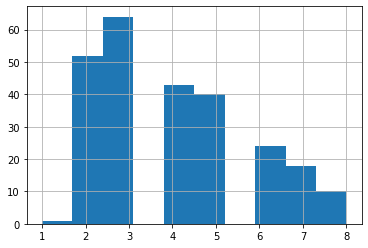

In [78]:
df2.Weeks_Since_Orig.hist()

In [88]:
# Create bins for each week
bins = np.arange(0, df["Weeks_Since_Orig"].max() + 2, 1)

# Assign rows to bins
df1["Week_Bin"] = 

,Application_ID,PortFolioID,CustType,OriginatedAmount,OrigYear,OrigMonth,OrigWeek,OriginationDate,FPDFA,FPDAA,TotalRealizedPayin,InstallmentNumber,PaidOffPaymentAmount,TransactionDate,PmtYear,PmtMonth,Days_Since_Orig,Weeks_Since_Orig,PaymentType,Payment_Number,PaymentStatus,weeks_between_orig_now,Week_Bin
LoanID,,,,,,,,,,,,,,,,,,,,,,,
I306-0,784,1,NEW,500.0,2023,5,20,2023-05-15 11:06:53.470,1.0,1.0,135.45,1,135.45,2023-05-18 10:23:02.560,2023.0,5.0,3.0,1.0,Installment Pmt,1,R,35,"[1.0, 2.0)"
I106-0,352,1,NEW,300.0,2023,5,18,2023-05-04 16:17:12.987,0.0,0.0,129.25,1,82.45,2023-05-09 09:33:00.343,2023.0,5.0,5.0,1.0,Installment Pmt,1,D,37,"[1.0, 2.0)"
I212-0,565,1,NEW,500.0,2023,5,19,2023-05-10 12:08:55.370,1.0,1.0,135.45,1,135.45,2023-05-12 09:23:00.580,2023.0,5.0,2.0,1.0,Installment Pmt,1,R,36,"[1.0, 2.0)"
I422-0,1071,1,NEW,500.0,2023,5,20,2023-05-18 11:00:39.193,0.0,0.0,135.45,1,135.45,2023-05-24 09:53:01.240,2023.0,5.0,6.0,1.0,Installment Pmt,1,D,35,"[1.0, 2.0)"
I215-0,571,1,NEW,500.0,2023,5,19,2023-05-10 13:09:35.530,0.0,0.0,677.25,1,135.45,2023-05-12 09:23:00.610,2023.0,5.0,2.0,1.0,Installment Pmt,1,D,36,"[1.0, 2.0)"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
I1155-0,3244,1,NEW,500.0,2023,6,25,2023-06-23 11:04:17.503,1.0,1.0,526.80,2,135.45,2023-08-10 09:33:02.987,2023.0,8.0,48.0,7.0,Installment Pmt,2,R,30,"[7.0, 8.0)"
I2145-0,6128,1,NEW,750.0,2023,9,35,2023-09-01 11:38:01.640,0.0,0.0,0.00,1,201.70,2023-10-19 10:13:00.727,2023.0,10.0,48.0,7.0,Installment Pmt,1,R,20,"[7.0, 8.0)"
I1405-0,4091,1,NEW,500.0,2023,7,29,2023-07-21 14:26:20.573,0.0,0.0,0.00,1,135.45,2023-09-15 09:13:00.793,2023.0,9.0,56.0,9.0,Installment Pmt,1,R,26,"[9.0, 10.0)"


curve [ 5.  7.  9. 11. 13. 15. 17. 19. 21. 23.] [0.71922377 0.85029615 0.96351332 1.05887526 1.13638197 1.19603346
 1.23782973 1.26177077 1.26785658 1.25608717]


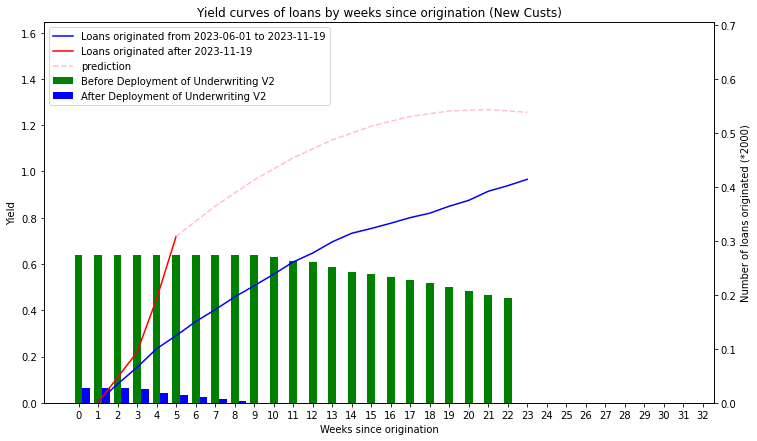

In [118]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Read table from CSV file or create DataFrame
# df = pd.read_csv("loan_payments.csv")

# Filter DataFrame by OriginationDate
df1 = df[(df["OriginationDate"] >= "2023-05-01") & (df["OriginationDate"] <= "2023-11-19") & (df.CustType=='NEW') & (~df.PaymentType.isin(['Reset Pmt', 'Arr Pmt']))]
df2 = df[(df["OriginationDate"] > "2023-11-19") & (df.CustType=='NEW')]

# Calculate total PaidOffPaymentAmount by grouping by Weeks_Since_Orig
df1_paid = df1[df1.PaymentStatus == 'D'].groupby("Weeks_Since_Orig")["PaidOffPaymentAmount"].sum().cumsum()
df2_paid = df2[df2.PaymentStatus == 'D'].groupby("Weeks_Since_Orig")["PaidOffPaymentAmount"].sum().cumsum()

# Transform the table by dropping duplicate rows for each LoanID and Weeks_Since_Orig
df1 = df1.groupby('LoanID').nth(0).sort_values(by='Weeks_Since_Orig')

df2 = df2.groupby('LoanID').nth(0).sort_values(by='Weeks_Since_Orig')

# Calculate total OriginatedAmount by grouping by Weeks_Since_Orig
df1_orig = pd.DataFrame()
df1_orig['Weeks'] = np.arange(0, df1["weeks_between_orig_now"].max(), 1)
df1_orig['Cumu_Orig'] = [df1[df1.weeks_between_orig_now>=i].OriginatedAmount.sum() for i in df1_orig['Weeks']]
df1_orig = df1_orig.set_index('Weeks')

# Calculate total OriginatedAmount by grouping by Weeks_Since_Orig
df2_orig = pd.DataFrame()
df2_orig['Weeks'] = np.arange(0, df2["weeks_between_orig_now"].max(), 1)
df2_orig['Cumu_Orig'] = [df2[df2.weeks_between_orig_now>=i].OriginatedAmount.sum() for i in df2_orig['Weeks']]
df2_orig = df2_orig.set_index('Weeks')


# Calculate yields
df1_yield = df1_paid / df1_orig['Cumu_Orig']
df2_yield = df2_paid / df2_orig['Cumu_Orig']
plt.figure(figsize = (12,7))

# Plot yield curves
plt.plot(df1_yield.index.astype(int)[:-2], df1_yield.values[:-2], color="blue", label="Loans originated from 2023-06-01 to 2023-11-19")
plt.plot(df2_yield.index.astype(int)[:-3], df2_yield.values[:-3], color="red", label="Loans originated after 2023-11-19")

x1 = df2_yield.index.astype(int)[-4]
x2 = df1_yield.dropna().index.astype(int)[22]
y1 = df2_yield.values[-4]
y2 = df1_yield.dropna().values[22]*1.3
m = 0.07

A = np.array([[x1**2, x1, 1], [x2**2, x2, 1], [2 * x1, 1, 0]])
b = np.array([y1, y2, m])
a, b, c = np.linalg.solve(A, b)

# Define the x and y values for the plot
x = np.linspace(x1, x2, 10) # 100 points between x1 and x2
y = a * x**2 + b * x + c # y values of the curve

# Plot the curve with a dashed line
print('curve',x,y)
plt.plot(x, y, linestyle='--', color='pink', label = 'prediction')


# Add title, labels, and legend
plt.title("Yield curves of loans by weeks since origination (New Custs)")
plt.xlabel("Weeks since origination")
plt.ylabel("Yield")
plt.xticks(df1_yield.index.astype(int))
# plt.legend()

# Create DataFrame with count of loans originated
df_count1 = df1.groupby("Weeks_Since_Orig").size().cumsum().to_frame("Count")
df_count2 = df2.groupby("Weeks_Since_Orig").size().cumsum().to_frame("Count")

df_count1 = pd.DataFrame()
df_count1['Weeks'] = np.arange(0, df1["Weeks_Since_Orig"].max()+4 , 1)
df_count1['Count'] = [len(df1[df1.weeks_between_orig_now>=i]) for i in df_count1['Weeks']]
df_count1 = df_count1.set_index('Weeks')

df_count2 = pd.DataFrame()
df_count2['Weeks'] = np.arange(0, df2["Weeks_Since_Orig"].max()+4, 1)
df_count2['Count'] = [len(df2[df2.weeks_between_orig_now>=i]) for i in df_count2['Weeks']]
df_count2 = df_count2.set_index('Weeks')

# Plot bar chart
plt.bar(df_count1.index, df_count1["Count"]*0.0005, width=0.4, color="green", label="Before Deployment of Underwriting V2")
plt.bar(df_count2.index+0.4, df_count2["Count"]*0.0005, width=0.4, color="blue", label="After Deployment of Underwriting V2")
plt.legend(loc='best')
# Add secondary y-axis label and adjust scale
plt.twinx()
plt.ylabel("Number of loans originated (*2000)")
plt.ylim(0, max(df_count1["Count"]) * 1.1*0.0005)




# Show plot
plt.show()

curve [ 5.  7.  9. 11. 13. 15. 17. 19. 21. 23.] [0.59813194 0.75012638 0.88610971 1.00608191 1.110043   1.19799297
 1.26993182 1.32585955 1.36577617 1.38968166]


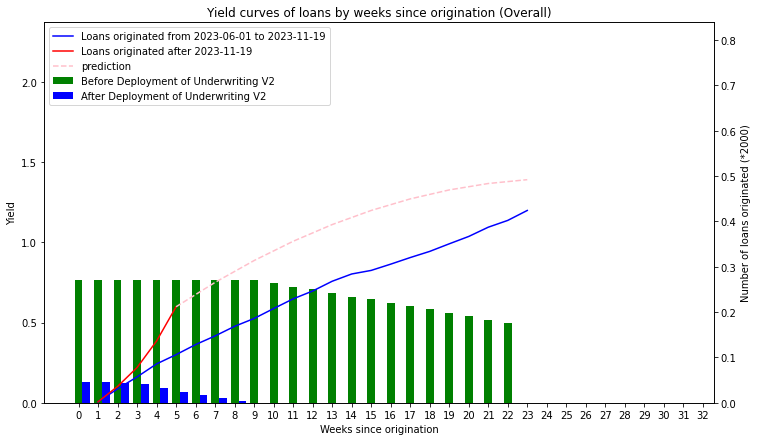

In [127]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Read table from CSV file or create DataFrame
# df = pd.read_csv("loan_payments.csv")

# Filter DataFrame by OriginationDate
df1 = df[(df["OriginationDate"] >= "2023-05-01") & (df["OriginationDate"] <= "2023-11-19") & (~df.PaymentType.isin(['Reset Pmt', 'Arr Pmt']))]
df2 = df[(df["OriginationDate"] > "2023-11-19")]

# Calculate total PaidOffPaymentAmount by grouping by Weeks_Since_Orig
df1_paid = df1[df1.PaymentStatus == 'D'].groupby("Weeks_Since_Orig")["PaidOffPaymentAmount"].sum().cumsum()
df2_paid = df2[df2.PaymentStatus == 'D'].groupby("Weeks_Since_Orig")["PaidOffPaymentAmount"].sum().cumsum()

# Transform the table by dropping duplicate rows for each LoanID and Weeks_Since_Orig
df1 = df1.groupby('LoanID').nth(0).sort_values(by='Weeks_Since_Orig')

df2 = df2.groupby('LoanID').nth(0).sort_values(by='Weeks_Since_Orig')

# Calculate total OriginatedAmount by grouping by Weeks_Since_Orig
df1_orig = pd.DataFrame()
df1_orig['Weeks'] = np.arange(0, df1["weeks_between_orig_now"].max(), 1)
df1_orig['Cumu_Orig'] = [df1[df1.weeks_between_orig_now>=i].OriginatedAmount.sum() for i in df1_orig['Weeks']]
df1_orig = df1_orig.set_index('Weeks')

# Calculate total OriginatedAmount by grouping by Weeks_Since_Orig
df2_orig = pd.DataFrame()
df2_orig['Weeks'] = np.arange(0, df2["weeks_between_orig_now"].max(), 1)
df2_orig['Cumu_Orig'] = [df2[df2.weeks_between_orig_now>=i].OriginatedAmount.sum() for i in df2_orig['Weeks']]
df2_orig = df2_orig.set_index('Weeks')


# Calculate yields
df1_yield = df1_paid / df1_orig['Cumu_Orig']
df2_yield = df2_paid / df2_orig['Cumu_Orig']
plt.figure(figsize = (12,7))

# Plot yield curves
plt.plot(df1_yield.index.astype(int)[:-2], df1_yield.values[:-2], color="blue", label="Loans originated from 2023-06-01 to 2023-11-19")
plt.plot(df2_yield.index.astype(int)[:-3], df2_yield.values[:-3], color="red", label="Loans originated after 2023-11-19")


x1 = df2_yield.index.astype(int)[-4]
x2 = df1_yield.dropna().index.astype(int)[22]
y1 = df2_yield.values[-4]
y2 = df1_yield.dropna().values[22]*1.16
m = 0.08

A = np.array([[x1**2, x1, 1], [x2**2, x2, 1], [2 * x1, 1, 0]])
b = np.array([y1, y2, m])
a, b, c = np.linalg.solve(A, b)

# Define the x and y values for the plot
x = np.linspace(x1, x2, 10) # 100 points between x1 and x2
y = a * x**2 + b * x + c # y values of the curve

# Plot the curve with a dashed line
print('curve',x,y)
plt.plot(x, y, linestyle='--', color='pink', label = 'prediction')


# Add title, labels, and legend
plt.title("Yield curves of loans by weeks since origination (Overall)")
plt.xlabel("Weeks since origination")
plt.ylabel("Yield")
plt.xticks(df1_yield.index.astype(int))
# plt.legend()

# Create DataFrame with count of loans originated
df_count1 = df1.groupby("Weeks_Since_Orig").size().cumsum().to_frame("Count")
df_count2 = df2.groupby("Weeks_Since_Orig").size().cumsum().to_frame("Count")

df_count1 = pd.DataFrame()
df_count1['Weeks'] = np.arange(0, df1["Weeks_Since_Orig"].max()+4 , 1)
df_count1['Count'] = [len(df1[df1.weeks_between_orig_now>=i]) for i in df_count1['Weeks']]
df_count1 = df_count1.set_index('Weeks')

df_count2 = pd.DataFrame()
df_count2['Weeks'] = np.arange(0, df2["Weeks_Since_Orig"].max()+4, 1)
df_count2['Count'] = [len(df2[df2.weeks_between_orig_now>=i]) for i in df_count2['Weeks']]
df_count2 = df_count2.set_index('Weeks')

# Plot bar chart
plt.bar(df_count1.index, df_count1["Count"]*0.0005, width=0.4, color="green", label="Before Deployment of Underwriting V2")
plt.bar(df_count2.index+0.4, df_count2["Count"]*0.0005, width=0.4, color="blue", label="After Deployment of Underwriting V2")
plt.legend(loc='best')
# Add secondary y-axis label and adjust scale
plt.twinx()
plt.ylabel("Number of loans originated (*2000)")
plt.ylim(0, max(df_count1["Count"]) * 1.1*0.0005)

# Show plot
plt.show()

curve [ 4.          5.22222222  6.44444444  7.66666667  8.88888889 10.11111111
 11.33333333 12.55555556 13.77777778 15.        ] [0.41585681 0.58881015 0.7410035  0.87243685 0.98311022 1.07302359
 1.14217698 1.19057037 1.21820378 1.22507719]


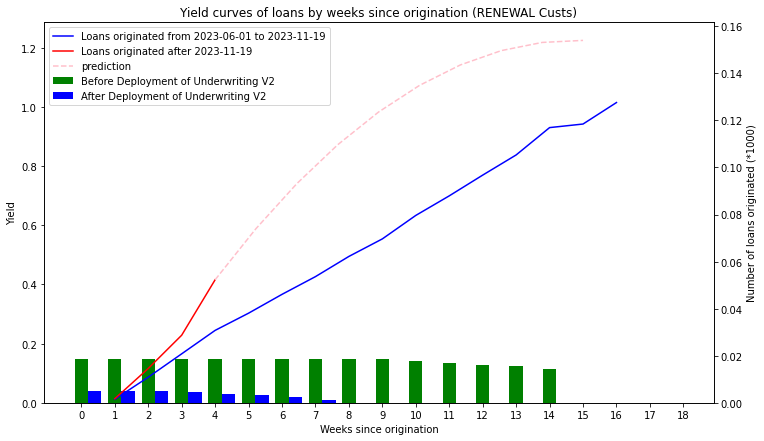

In [124]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Read table from CSV file or create DataFrame
# df = pd.read_csv("loan_payments.csv")

# Filter DataFrame by OriginationDate
df1 = df[(df["OriginationDate"] >= "2023-05-01") & (df["OriginationDate"] <= "2023-11-19") & (df.CustType == 'RENEWAL') & (~df.PaymentType.isin(['Reset Pmt', 'Arr Pmt']))]
df2 = df[(df["OriginationDate"] > "2023-11-19") & (df.CustType == 'RENEWAL')]

# Calculate total PaidOffPaymentAmount by grouping by Weeks_Since_Orig
df1_paid = df1[df1.PaymentStatus == 'D'].groupby("Weeks_Since_Orig")["PaidOffPaymentAmount"].sum().cumsum()
df2_paid = df2[df2.PaymentStatus == 'D'].groupby("Weeks_Since_Orig")["PaidOffPaymentAmount"].sum().cumsum()

# Transform the table by dropping duplicate rows for each LoanID and Weeks_Since_Orig
df1 = df1.groupby('LoanID').nth(0).sort_values(by='Weeks_Since_Orig')

df2 = df2.groupby('LoanID').nth(0).sort_values(by='Weeks_Since_Orig')

# Calculate total OriginatedAmount by grouping by Weeks_Since_Orig
df1_orig = pd.DataFrame()
df1_orig['Weeks'] = np.arange(0, df1["weeks_between_orig_now"].max(), 1)
df1_orig['Cumu_Orig'] = [df1[df1.weeks_between_orig_now>=i].OriginatedAmount.sum() for i in df1_orig['Weeks']]
df1_orig = df1_orig.set_index('Weeks')

# Calculate total OriginatedAmount by grouping by Weeks_Since_Orig
df2_orig = pd.DataFrame()
df2_orig['Weeks'] = np.arange(0, df2["weeks_between_orig_now"].max(), 1)
df2_orig['Cumu_Orig'] = [df2[df2.weeks_between_orig_now>=i].OriginatedAmount.sum() for i in df2_orig['Weeks']]
df2_orig = df2_orig.set_index('Weeks')


# Calculate yields
df1_yield = df1_paid / df1_orig['Cumu_Orig']
df2_yield = df2_paid / df2_orig['Cumu_Orig']
plt.figure(figsize = (12,7))

# Plot yield curves
plt.plot(df1_yield.index.astype(int)[:-2], df1_yield.values[:-2], color="blue", label="Loans originated from 2023-06-01 to 2023-11-19")
plt.plot(df2_yield.index.astype(int)[:-3], df2_yield.values[:-3], color="red", label="Loans originated after 2023-11-19")

x1 = df2_yield.index.astype(int)[-4]
x2 = df1_yield.dropna().index.astype(int)[14]
y1 = df2_yield.values[-4]
y2 = df1_yield.dropna().values[14]*1.3
m = 0.15

A = np.array([[x1**2, x1, 1], [x2**2, x2, 1], [2 * x1, 1, 0]])
b = np.array([y1, y2, m])
a, b, c = np.linalg.solve(A, b)

# Define the x and y values for the plot
x = np.linspace(x1, x2, 10) # 100 points between x1 and x2
y = a * x**2 + b * x + c # y values of the curve

# Plot the curve with a dashed line
plt.plot(x, y, linestyle='--', color='pink', label = 'prediction')


# Add title, labels, and legend
plt.title("Yield curves of loans by weeks since origination (RENEWAL Custs)")
plt.xlabel("Weeks since origination")
plt.ylabel("Yield")
plt.xticks(df1_yield.index.astype(int))
# plt.legend()

# Create DataFrame with count of loans originated
df_count1 = df1.groupby("Weeks_Since_Orig").size().cumsum().to_frame("Count")
df_count2 = df2.groupby("Weeks_Since_Orig").size().cumsum().to_frame("Count")

df_count1 = pd.DataFrame()
df_count1['Weeks'] = np.arange(0, df1["Weeks_Since_Orig"].max()+4 , 1)
df_count1['Count'] = [len(df1[df1.weeks_between_orig_now>=i]) for i in df_count1['Weeks']]
df_count1 = df_count1.set_index('Weeks')

df_count2 = pd.DataFrame()
df_count2['Weeks'] = np.arange(0, df2["Weeks_Since_Orig"].max()+4, 1)
df_count2['Count'] = [len(df2[df2.weeks_between_orig_now>=i]) for i in df_count2['Weeks']]
df_count2 = df_count2.set_index('Weeks')

# Plot bar chart
plt.bar(df_count1.index, df_count1["Count"]*0.001, width=0.4, color="green", label="Before Deployment of Underwriting V2")
plt.bar(df_count2.index+0.4, df_count2["Count"]*0.001, width=0.4, color="blue", label="After Deployment of Underwriting V2")
plt.legend(loc='best')
# Add secondary y-axis label and adjust scale
plt.twinx()
plt.ylabel("Number of loans originated (*1000)")
plt.ylim(0, max(df_count1["Count"]) * 1.1*0.001)

# Show plot
plt.show()

curve [ 5.  6.  7.  8.  9. 10. 11. 12. 13. 14.] [0.56842649 0.71077458 0.83781887 0.94955935 1.04599603 1.12712889
 1.19295795 1.2434832  1.27870465 1.29862229]


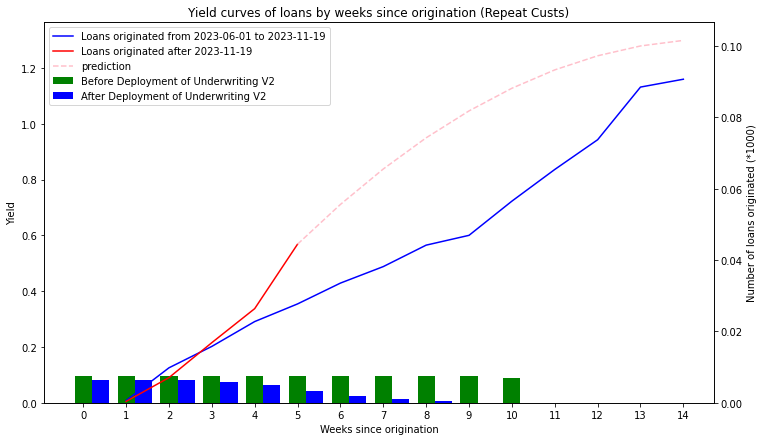

In [132]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Read table from CSV file or create DataFrame
# df = pd.read_csv("loan_payments.csv")

# Filter DataFrame by OriginationDate
df1 = df[(df["OriginationDate"] >= "2023-05-01") & (df["OriginationDate"] <= "2023-11-19") & (df.CustType == 'REPEAT') & (~df.PaymentType.isin(['Reset Pmt', 'Arr Pmt']))]
df2 = df[(df["OriginationDate"] > "2023-11-19") & (df.CustType == 'REPEAT')]

# Calculate total PaidOffPaymentAmount by grouping by Weeks_Since_Orig
df1_paid = df1[df1.PaymentStatus == 'D'].groupby("Weeks_Since_Orig")["PaidOffPaymentAmount"].sum().cumsum()
df2_paid = df2[df2.PaymentStatus == 'D'].groupby("Weeks_Since_Orig")["PaidOffPaymentAmount"].sum().cumsum()

# Transform the table by dropping duplicate rows for each LoanID and Weeks_Since_Orig
df1 = df1.groupby('LoanID').nth(0).sort_values(by='Weeks_Since_Orig')

df2 = df2.groupby('LoanID').nth(0).sort_values(by='Weeks_Since_Orig')

# Calculate total OriginatedAmount by grouping by Weeks_Since_Orig
df1_orig = pd.DataFrame()
df1_orig['Weeks'] = np.arange(0, df1["weeks_between_orig_now"].max()-20, 1)
df1_orig['Cumu_Orig'] = [df1[df1.weeks_between_orig_now>=i].OriginatedAmount.sum() for i in df1_orig['Weeks']]
df1_orig = df1_orig.set_index('Weeks')

# Calculate total OriginatedAmount by grouping by Weeks_Since_Orig
df2_orig = pd.DataFrame()
df2_orig['Weeks'] = np.arange(0, df2["weeks_between_orig_now"].max(), 1)
df2_orig['Cumu_Orig'] = [df2[df2.weeks_between_orig_now>=i].OriginatedAmount.sum() for i in df2_orig['Weeks']]
df2_orig = df2_orig.set_index('Weeks')


# Calculate yields
df1_yield = df1_paid / df1_orig['Cumu_Orig']
df2_yield = df2_paid / df2_orig['Cumu_Orig']
plt.figure(figsize = (12,7))

# Plot yield curves
plt.plot(df1_yield.index.astype(int)[:-3], df1_yield.values[:-3], color="blue", label="Loans originated from 2023-06-01 to 2023-11-19")
plt.plot(df2_yield.index.astype(int)[:-3], df2_yield.values[:-3], color="red", label="Loans originated after 2023-11-19")

x1 = df2_yield.index.astype(int)[-4]
x2 = df1_yield.dropna().index.astype(int)[13]
y1 = df2_yield.values[-4]
y2 = df1_yield.dropna().values[13]*1.12
m = 0.15

A = np.array([[x1**2, x1, 1], [x2**2, x2, 1], [2 * x1, 1, 0]])
b = np.array([y1, y2, m])
a, b, c = np.linalg.solve(A, b)

# Define the x and y values for the plot
x = np.linspace(x1, x2, 10) # 100 points between x1 and x2
y = a * x**2 + b * x + c # y values of the curve

# Plot the curve with a dashed line
plt.plot(x, y, linestyle='--', color='pink', label = 'prediction')

# Add title, labels, and legend
plt.title("Yield curves of loans by weeks since origination (Repeat Custs)")
plt.xlabel("Weeks since origination")
plt.ylabel("Yield")
plt.xticks(df1_yield.index.astype(int))
# plt.legend()

# Create DataFrame with count of loans originated
df_count1 = df1.groupby("Weeks_Since_Orig").size().cumsum().to_frame("Count")
df_count2 = df2.groupby("Weeks_Since_Orig").size().cumsum().to_frame("Count")

df_count1 = pd.DataFrame()
df_count1['Weeks'] = np.arange(0, df1["Weeks_Since_Orig"].max()+4 , 1)
df_count1['Count'] = [len(df1[df1.weeks_between_orig_now>=i]) for i in df_count1['Weeks']]
df_count1 = df_count1.set_index('Weeks')

df_count2 = pd.DataFrame()
df_count2['Weeks'] = np.arange(0, df2["Weeks_Since_Orig"].max()+4, 1)
df_count2['Count'] = [len(df2[df2.weeks_between_orig_now>=i]) for i in df_count2['Weeks']]
df_count2 = df_count2.set_index('Weeks')

# Plot bar chart
plt.bar(df_count1.index, df_count1["Count"]*0.001, width=0.4, color="green", label="Before Deployment of Underwriting V2")
plt.bar(df_count2.index+0.4, df_count2["Count"]*0.001, width=0.4, color="blue", label="After Deployment of Underwriting V2")
plt.legend(loc='best')
# Add secondary y-axis label and adjust scale
plt.twinx()
plt.ylabel("Number of loans originated (*1000)")
plt.ylim(0, max(df_count1["Count"]) * 1.1*0.001)

# Show plot
plt.show()

In [117]:
df1_paid / df1_orig['Cumu_Orig']

0.0           NaN
1.0      0.004348
2.0      0.080785
3.0      0.153560
4.0      0.233705
5.0      0.290390
6.0      0.350907
7.0      0.402599
8.0      0.457482
9.0      0.506030
10.0     0.555659
11.0     0.608852
12.0     0.647423
13.0     0.695608
14.0     0.732896
15.0     0.753616
16.0     0.776293
17.0     0.800629
18.0     0.819767
19.0     0.849896
20.0     0.875267
21.0     0.914546
22.0     0.938675
23.0     0.966221
24.0          NaN
25.0          NaN
26.0     1.181708
27.0          NaN
28.0          NaN
29.0          NaN
30.0          NaN
31.0     1.566776
32.0          NaN
33.0          NaN
34.0          NaN
35.0          NaN
36.0          NaN
37.0    21.540608
38.0          NaN
dtype: float64

In [119]:
df1_yield.index.astype(int)[:-2]

Int64Index([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
            17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
            34, 35, 36],
           dtype='int64')

In [143]:
df_count1.fillna(method='bfill')

,Count
Weeks_Since_Orig,
1.0,33
2.0,594
3.0,1076
4.0,1242
5.0,1263
6.0,1276
7.0,1279
9.0,1280
14.0,1281


In [146]:
# Create a new index with all the values from 1 to 19
new_index = pd.Index(np.arange(1, 20), name="Weeks_Since_Orig")

# Reindex the DataFrame with the new index and fill the missing values with Null
df_count1.reindex(new_index)


,Count
Weeks_Since_Orig,
1,33.0
2,594.0
3,1076.0
4,1242.0
5,1263.0
6,1276.0
7,1279.0
8,NaN
9,1280.0


In [8]:
### With Proj